# load lib

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import time
import os
from tempfile import TemporaryDirectory
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.metrics.road import ROADMostRelevantFirst
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns


# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = '/home/natthakit/304proj/dataset'


# Load the saved state dictionary into this model.

In [2]:
def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    
def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    # Print the metrics
    print(f'Accuracy: {acc:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    plot_confusion_matrix(conf_matrix)

    return acc, precision, recall, f1, conf_matrix

In [3]:
def create_df(file_path):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    # Read the log file
    with open(file_path, "r") as file:
        for line in file:
            # Extract train Loss and Acc values
            train_match = re.search(r"train Loss: ([0-9.]+) Acc: ([0-9.]+)", line)
            if train_match:
                train_losses.append(float(train_match.group(1)))
                train_accuracies.append(float(train_match.group(2)))
    
            # Extract val Loss and Acc values
            val_match = re.search(r"val Loss: ([0-9.]+) Acc: ([0-9.]+)", line)
            if val_match:
                val_losses.append(float(val_match.group(1)))
                val_accuracies.append(float(val_match.group(2)))
    
    # Create the DataFrame
    df = pd.DataFrame({
        "train Loss": train_losses,
        "train Acc": train_accuracies,
        "val Loss": val_losses,
        "val Acc": val_accuracies
    })

    plt.subplot(1, 2, 1)
    plt.plot(df.index, df['train Loss'], label='Train Loss', marker='o')
    plt.plot(df.index, df['val Loss'], label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(df.index, df['train Acc'], label='Train Accuracy', marker='o')
    plt.plot(df.index, df['val Acc'], label='Validation Accuracy', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    return df


# RESNET50

## load model

In [4]:
# Load the entire model
resnet50_model = torch.load('saved/resnet50_full_model.pth')
resnet50_model = resnet50_model.to(device)  # Move to the correct device

## evaluation

In [5]:
data_transforms_resnet50 = {
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
image_datasets_resnet50 = {'test': ImageFolder(os.path.join(data_dir, 'test'), data_transforms_resnet50['test'])}
dataloaders_resnet50 = {'test': DataLoader(image_datasets_resnet50['test'], batch_size=32, shuffle=True, num_workers=4)}

Accuracy: 0.9962
Precision: 0.9963
Recall: 0.9962
F1 Score: 0.9962


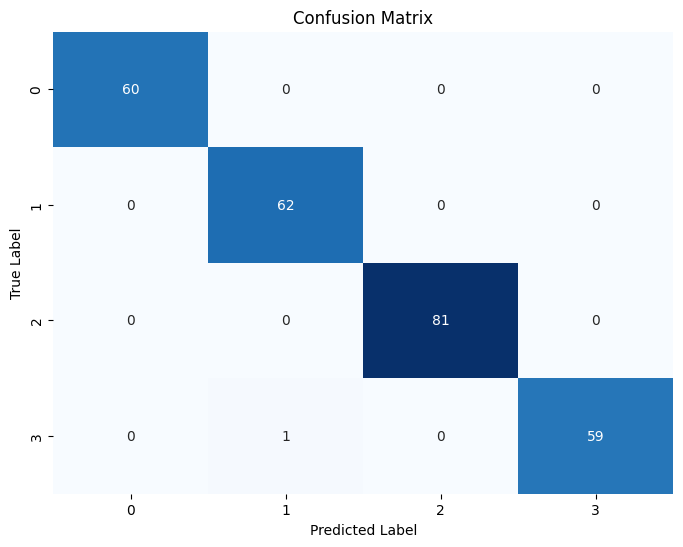

In [6]:
acc, precision, recall, f1, conf_matrix = evaluate_model(resnet50_model, dataloaders_resnet50['test'])

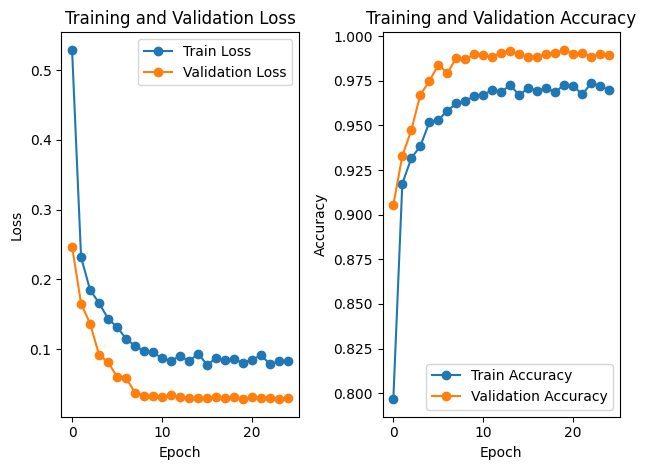

In [7]:
report = create_df('logger/resnet50_log.txt')

# SWINV2_S

## load model

In [16]:
# Load the entire model
swin_model = torch.load('saved/swinv2_s_full_model.pth')
swin_model = swin_model.to(device)  # Move to the correct device

## evaluation

In [17]:
data_transforms_swinv2_s = {
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets_swinv2_s = {'test': ImageFolder(os.path.join(data_dir, 'test'), data_transforms_swinv2_s['test'])}
dataloaders_swinv2_s = {'test': DataLoader(image_datasets_swinv2_s['test'], batch_size=32, shuffle=True, num_workers=4)}

Accuracy: 0.9886
Precision: 0.9888
Recall: 0.9886
F1 Score: 0.9886


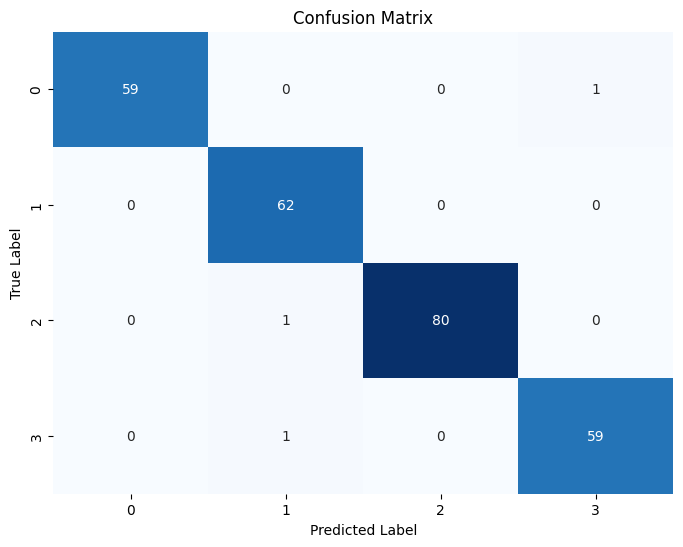

In [18]:
acc, precision, recall, f1, conf_matrix = evaluate_model(swin_model, dataloaders_swinv2_s['test'])

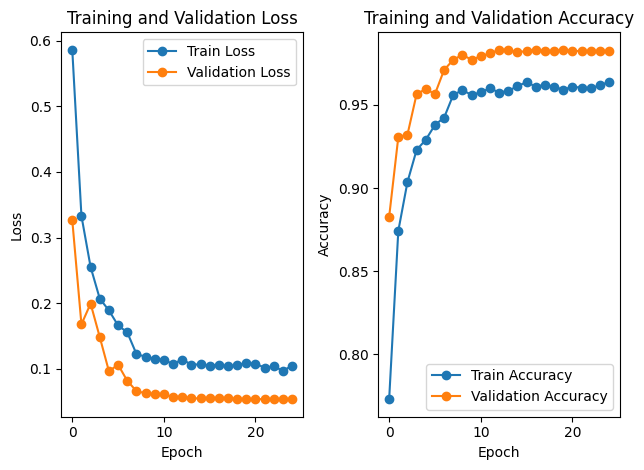

In [12]:
report = create_df('logger/swinv2_s_log.txt')

# maxvit-t

## load model

In [13]:
# Load the entire model
maxvit_model = torch.load('saved/new_maxvit_T_full_model.pth')
maxvit_model = maxvit_model.to(device)  # Move to the correct device


## evaluation

In [19]:
data_transforms_maxvit = {
    'test': transforms.Compose([
        transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
}

image_datasets_maxvit = {'test': ImageFolder(os.path.join(data_dir, 'test'), data_transforms_maxvit['test'])}
dataloaders_maxvit = {'test': DataLoader(image_datasets_maxvit['test'], batch_size=32, shuffle=True, num_workers=4)}

Accuracy: 0.9886
Precision: 0.9891
Recall: 0.9886
F1 Score: 0.9887


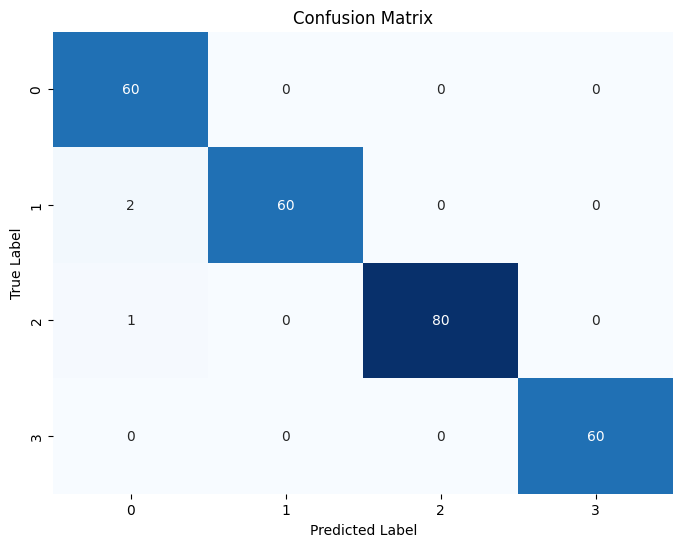

In [20]:
acc, precision, recall, f1, conf_matrix = evaluate_model(maxvit_model, dataloaders_maxvit['test'])

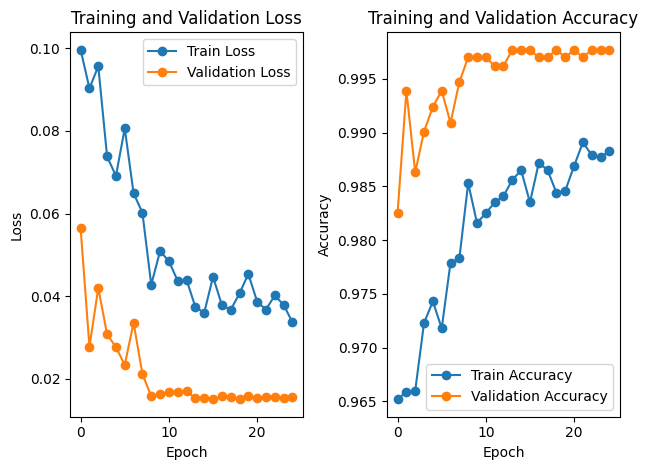

In [21]:
report = create_df('logger/maxvit_T_log.txt')

#  EfficientNetV2 small

## load model

In [23]:
eff_s_model = torch.load('saved/eff_s_full_model.pth')
eff_s_model = eff_s_model.to(device)  # Move to the correct device


## evaluation

In [24]:
data_transforms_eff_s = {
    'test': transforms.Compose([
        transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

image_datasets_eff_s = {'test': ImageFolder(os.path.join(data_dir, 'test'), data_transforms_eff_s['test']) }
dataloaders_eff_s = {'test': DataLoader(image_datasets_eff_s['test'], batch_size=32, shuffle=True, num_workers=4) }

Accuracy: 0.9962
Precision: 0.9963
Recall: 0.9962
F1 Score: 0.9962


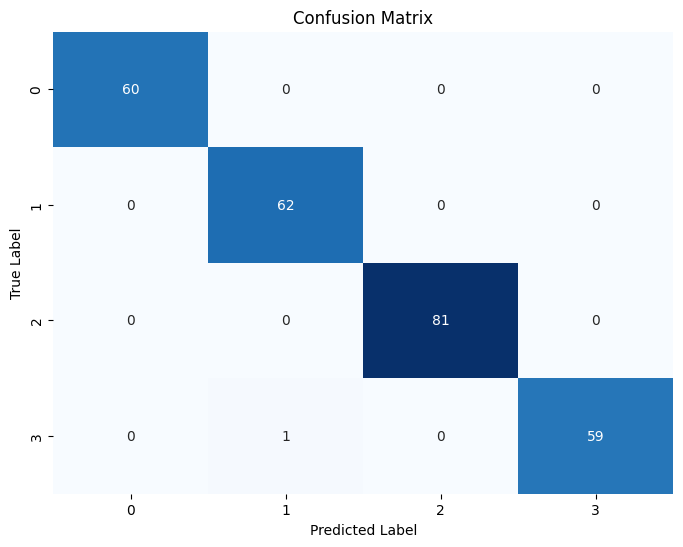

In [25]:
acc, precision, recall, f1, conf_matrix = evaluate_model(eff_s_model, dataloaders_eff_s['test'])

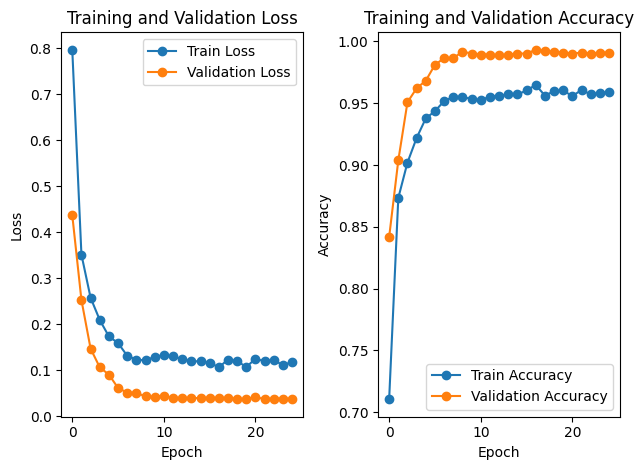

In [26]:
report = create_df('logger/eff_s_log.txt')